In [87]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import lit

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

## Ranking System

Ranking System uses the following features:
- future predictions for transactions per merchant per month
- future predictions for profit per merchant per month
- future predictions for customers within revenue range \\$50k-\\$75k per month
- population (quartiles) of young adults and middle aged adults based on postcodes of consumers

Read all data needed for above features

In [88]:
future_trans_sdf = spark.read.parquet("../data/curated/futuretrans.parquet/")
future_trans_sdf.limit(5)

year,month,merchant_abn,total_transactions
2023,5,80121625734,36.85885854384651
2023,5,10187291046,43.94976345056075
2023,5,32772607667,56.982676773785485
2023,5,19633197919,44.95620568112244
2023,5,18737319630,38.9600224762402


In [89]:
future_profit_sdf = spark.read.parquet("../data/curated/futureprofit.parquet/")
future_profit_sdf.limit(5)

year,month,merchant_abn,total_profit
2023,5,80121625734,718.7299519941164
2023,5,10187291046,321.20928697548646
2023,5,32772607667,382.856836584368
2023,5,19633197919,909.3521069894532
2023,5,18737319630,368.7870030808791


In [90]:
future_mcustomers_sdf = spark.read.parquet("../data/curated/futuremcustomers.parquet/")
future_mcustomers_sdf.limit(5)

year,month,merchant_abn,total_middle_customers
2023,4,67610254313,8.911459530226823
2023,4,76241460849,6.598423723172958
2023,4,86201937910,6.298368461310957
2023,4,53126107676,98.7534217787489
2023,4,94547309480,14.325967064940135


In [91]:
merch_pop = spark.read.parquet("../data/curated/merch_pop.parquet/")
merch_pop.limit(5)

merchant_abn,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop
10255988167,2,2,3,2,2,4
10430380319,3,3,3,3,3,3
10618089367,4,4,4,4,4,4
11215815177,1,1,1,1,1,1
11237511112,4,4,4,4,4,4


Create a pandas dataframe that will store all the points for each merchant

In [92]:
merch_points_pd = future_trans_sdf \
    .select('merchant_abn') \
    .distinct() \
    .withColumns({
        'total_points': lit(1),
        'pop_points': lit(0),
        'trans_points': lit(0),
        'profit_points': lit(0),
        'mcust_points': lit(0)
    }) \
    .orderBy("merchant_abn") \
    .toPandas()

merch_points_pd

,merchant_abn,total_points,pop_points,trans_points,profit_points,mcust_points
0,10023283211,1,0,0,0,0
1,10142254217,1,0,0,0,0
2,10165489824,1,0,0,0,0
3,10187291046,1,0,0,0,0
4,10192359162,1,0,0,0,0
...,...,...,...,...,...,...
4013,99938978285,1,0,0,0,0
4014,99974311662,1,0,0,0,0
4015,99976658299,1,0,0,0,0
4016,99987905597,1,0,0,0,0


Have 4018 distinct merchants, need to select top 100 merchants

Idea:
- all merchants have initial points 1
- the more the number of points, the higher/better the rank will be
- points given based on sorted positioning within the features and importance of the feature (for transaction, profit, and mcustomers)

In [93]:
WEIGHT_TRANS = 0.375
WEIGHT_PROFIT = 0.375
WEIGHT_MCUSTOMERS = 0.125
WEIGHT_POP = 0.125

***

Award 0.125 points to merchants having a relatively large young adult and middle age population (external research) <br>
with 'large' meaning the populations are above the lower quartile (not group 1 - see notebook 4.4)

In [94]:
w = Window.partitionBy('month')

merch_pop_mod = merch_pop \
    .drop(*("total_pop", "under10_pop", "adolsc_pop", "old_pop")) \
    .withColumn(
        "points",
        when(
            (col("yng_adult_pop") != 1) &
            (col("mid_age_pop") != 1),
            lit(0.125)
        ).otherwise(lit(0))
    ) \
    .drop(*("yng_adult_pop", "mid_age_pop")) \
    .orderBy("merchant_abn")

merch_pop_mod.limit(10)

merchant_abn,points
10023283211,0.0
10142254217,0.0
10165489824,0.125
10187291046,0.125
10192359162,0.125
10206519221,0.0
10255988167,0.125
10264435225,0.0
10279061213,0.0
10323485998,0.125


In [95]:
merch_pop_mod_df = merch_pop_mod.toPandas()
merch_pop_mod_df

,merchant_abn,points
0,10023283211,0.000
1,10142254217,0.000
2,10165489824,0.125
3,10187291046,0.125
4,10192359162,0.125
...,...,...
4013,99938978285,0.000
4014,99974311662,0.000
4015,99976658299,0.125
4016,99987905597,0.125


In [96]:
merch_points_pd["total_points"] = merch_points_pd["total_points"] + merch_pop_mod_df["points"]
merch_points_pd['pop_points'] = merch_points_pd['pop_points'] + merch_pop_mod_df["points"]
merch_points_pd

,merchant_abn,total_points,pop_points,trans_points,profit_points,mcust_points
0,10023283211,1.000,0.000,0,0,0
1,10142254217,1.000,0.000,0,0,0
2,10165489824,1.125,0.125,0,0,0
3,10187291046,1.125,0.125,0,0,0
4,10192359162,1.125,0.125,0,0,0
...,...,...,...,...,...,...
4013,99938978285,1.000,0.000,0,0,0
4014,99974311662,1.000,0.000,0,0,0
4015,99976658299,1.125,0.125,0,0,0
4016,99987905597,1.125,0.125,0,0,0


***

Get the merchant with the highest number of total transactions for each month (`ft_agg2`):

In [97]:
w = Window.partitionBy('month')

ft_agg2 = future_trans_sdf \
    .withColumn('maxT', F.max('total_transactions').over(w)) \
    .where(F.col('total_transactions') == F.col('maxT')) \
    .drop('maxT')

ft_agg2

year,month,merchant_abn,total_transactions
2023,1,24852446429,12706.867430622047
2023,2,24852446429,12725.976797500647
2023,3,24852446429,12601.879475370839
2023,4,24852446429,12624.618672374758
2023,5,24852446429,12557.475159081536
2023,6,24852446429,12576.861500222918
2023,7,24852446429,12540.356167994907
2023,8,24852446429,12555.113743323984
2023,9,24852446429,12535.352343858927
2023,10,24852446429,12546.091227819079


__[reference for above code](https://stackoverflow.com/questions/48829993/groupby-column-and-filter-rows-with-maximum-value-in-pyspark)__



For each month, order the merchants by increasing order of their total transactions <br>
(merchant with lowest number of transactions for that month will be at the top)

In [98]:
ordered_ft_pd = future_trans_sdf \
    .orderBy(asc("month"), asc("total_transactions")) \
    .drop("year") \
    .toPandas()

ordered_ft_pd

,month,merchant_abn,total_transactions
0,1,62346852889,21.097950
1,1,35235320738,21.149586
2,1,86791380020,21.154814
3,1,34455283435,21.199792
4,1,98082781436,21.204058
...,...,...,...
48211,12,46804135891,10163.244846
48212,12,49891706470,10724.271327
48213,12,64203420245,11311.885569
48214,12,86578477987,11805.480411


Note for below that `groupby` preserves ordering within each group

In [99]:
merch_abns = list(merch_points_pd["merchant_abn"])

MONTHS = 12
for i in range(1, MONTHS+1):
    new_points = []
    
    month_data = ordered_ft_pd.groupby("month").get_group(i)
    month_data = pd.DataFrame(month_data.reset_index().drop(columns="index"))
    
    for abn in merch_abns:
        try:
            # the larger the index, the more transactions the merchant will have (ordered data)
            # thus more points awarded
            points = np.round(WEIGHT_TRANS*list(month_data.index[month_data["merchant_abn"] == abn])[0], 3)
        except IndexError:
            # have no data for the current abn
            points = 0

        new_points.append(points)

    merch_points_pd["total_points"] = merch_points_pd["total_points"] + new_points
    merch_points_pd["trans_points"] = merch_points_pd["trans_points"] + new_points

In [100]:
merch_points_pd

,merchant_abn,total_points,pop_points,trans_points,profit_points,mcust_points
0,10023283211,14680.750,0.000,14679.750,0,0
1,10142254217,14446.000,0.000,14445.000,0,0
2,10165489824,184.125,0.125,183.000,0,0
3,10187291046,8435.625,0.125,8434.500,0,0
4,10192359162,8808.000,0.125,8806.875,0,0
...,...,...,...,...,...,...
4013,99938978285,17421.250,0.000,17420.250,0,0
4014,99974311662,5447.875,0.000,5446.875,0,0
4015,99976658299,17627.625,0.125,17626.500,0,0
4016,99987905597,6729.750,0.125,6728.625,0,0


***

Get the merchant with the highest profit for each month (`fp_agg2`):

In [101]:
w = Window.partitionBy('month')

fp_agg2 = future_profit_sdf \
    .withColumn('maxP', F.max('total_profit').over(w)) \
    .where(F.col('total_profit') == F.col('maxP')) \
    .drop('maxP')

fp_agg2

year,month,merchant_abn,total_profit
2023,1,32361057556,27740.570878728235
2023,2,32361057556,27878.7679430336
2023,3,32361057556,27552.75259841377
2023,4,32361057556,27653.557096675115
2023,5,32361057556,27479.095309639102
2023,6,32361057556,27551.766701347373
2023,7,32361057556,27461.515288951385
2023,8,32361057556,27514.536693437625
2023,9,32361057556,27471.280954645557
2023,10,32361057556,27511.178900430907


For each month, order the merchants by increasing order of their total profit <br>
(merchant with lowest total profit for that month at the top)

In [102]:
ordered_fp_pd = future_profit_sdf \
    .orderBy(asc("month"), asc("total_profit")) \
    .drop("year") \
    .toPandas()

ordered_fp_pd

,month,merchant_abn,total_profit
0,1,16156289887,169.090896
1,1,86791380020,177.765852
2,1,33068332703,179.699605
3,1,10441711491,179.786133
4,1,21350600012,179.972700
...,...,...,...
48211,12,96680767841,25475.481580
48212,12,45629217853,25860.368887
48213,12,86578477987,27096.311961
48214,12,48534649627,27268.520005


In [103]:
for i in range(1, MONTHS+1):
    new_points = []
    
    month_data = ordered_fp_pd.groupby("month").get_group(i)
    month_data = pd.DataFrame(month_data.reset_index().drop(columns="index"))
    
    for abn in merch_abns:
        try:
            # the larger the index, the more profit the merchant will have (ordered data)
            # thus more points awarded
            points = np.round(WEIGHT_PROFIT*list(month_data.index[month_data["merchant_abn"] == abn])[0], 3)
        except IndexError:
            # have no data for the current abn
            points = 0

        new_points.append(points)

    merch_points_pd["total_points"] = merch_points_pd["total_points"] + new_points
    merch_points_pd["profit_points"] = merch_points_pd["total_points"] + new_points

In [104]:
merch_points_pd

,merchant_abn,total_points,pop_points,trans_points,profit_points,mcust_points
0,10023283211,18909.250,0.000,14679.750,19261.000,0
1,10142254217,23638.000,0.000,14445.000,24405.625,0
2,10165489824,3668.250,0.125,183.000,3918.000,0
3,10187291046,12815.250,0.125,8434.500,13181.250,0
4,10192359162,20447.250,0.125,8806.875,21416.250,0
...,...,...,...,...,...,...
4013,99938978285,31240.375,0.000,17420.250,32392.375,0
4014,99974311662,8866.000,0.000,5446.875,9155.875,0
4015,99976658299,35401.875,0.125,17626.500,36883.125,0
4016,99987905597,15740.250,0.125,6728.625,16495.125,0


***

Get the merchant with the highest number of middle customers for each month (`fmc_agg2`):

In [105]:
w = Window.partitionBy('month')

fmc_agg2 = future_mcustomers_sdf \
    .withColumn('maxMC', F.max('total_middle_customers').over(w)) \
    .where(F.col('total_middle_customers') == F.col('maxMC')) \
    .drop('maxMC')

fmc_agg2

year,month,merchant_abn,total_middle_customers
2023,1,24852446429,2796.8587999146635
2023,2,24852446429,2794.892202393302
2023,3,24852446429,2781.9611881292603
2023,4,24852446429,2781.828716128044
2023,5,24852446429,2775.997045578518
2023,6,24852446429,2776.425821608259
2023,7,24852446429,2773.9088483222054
2023,8,24852446429,2774.4608952929357
2023,9,24852446429,2773.4974495653432
2023,10,24852446429,2774.0415413334777


For each month, order the merchants by increasing order of their total predicted population of middle income earning customers <br>

In [106]:
ordered_fmc_pd = future_mcustomers_sdf \
    .orderBy(asc("month"), asc("total_middle_customers")) \
    .drop("year") \
    .toPandas()

ordered_fmc_pd

,month,merchant_abn,total_middle_customers
0,1,28836033916,4.850240
1,1,14626521979,4.850240
2,1,37670671283,4.850240
3,1,37706925794,4.850240
4,1,95594775419,4.850240
...,...,...,...
48211,12,46804135891,2379.631110
48212,12,49891706470,2465.908543
48213,12,64203420245,2576.013135
48214,12,86578477987,2670.840636


In [107]:
for i in range(1, MONTHS+1):
    new_points = []
    
    month_data = ordered_fmc_pd.groupby("month").get_group(i)
    month_data = pd.DataFrame(month_data.reset_index().drop(columns="index"))
    
    for abn in merch_abns:
        try:
            # the larger the index, the more profit the merchant will have (ordered data)
            # thus more points awarded
            points = np.round(WEIGHT_MCUSTOMERS*list(month_data.index[month_data["merchant_abn"] == abn])[0], 3)
        except IndexError:
            # have no data for the current abn
            points = 0

        new_points.append(points)

    merch_points_pd["total_points"] = merch_points_pd["total_points"] + new_points
    merch_points_pd["mcust_points"] = merch_points_pd["mcust_points"] + new_points

In [108]:
merch_points_pd

,merchant_abn,total_points,pop_points,trans_points,profit_points,mcust_points
0,10023283211,23850.625,0.000,14679.750,19261.000,4941.375
1,10142254217,28458.250,0.000,14445.000,24405.625,4820.250
2,10165489824,3754.500,0.125,183.000,3918.000,86.250
3,10187291046,15534.750,0.125,8434.500,13181.250,2719.500
4,10192359162,23528.500,0.125,8806.875,21416.250,3081.250
...,...,...,...,...,...,...
4013,99938978285,37048.125,0.000,17420.250,32392.375,5807.750
4014,99974311662,10775.875,0.000,5446.875,9155.875,1909.875
4015,99976658299,41278.625,0.125,17626.500,36883.125,5876.750
4016,99987905597,17827.500,0.125,6728.625,16495.125,2087.250


In [109]:
spark.createDataFrame(merch_points_pd).write.mode("overwrite").parquet("../data/curated/merch_points.parquet")

***

Get the top 100 merchants

In [110]:
merchants_sdf = spark.read.parquet("../data/curated/merchantdf.parquet/")
merchants_sdf.limit(5)

company_name,tags,merchant_abn,take_rate,revenue_band
Felis Limited,"furniture, home f...",10023283211,0.18,e
Arcu Ac Orci Corp...,"cable, satellite,...",10142254217,4.22,b
Nunc Sed Company,"jewelry, watch, c...",10165489824,4.40,b
Ultricies Digniss...,"watch, clock, and...",10187291046,3.29,b
Enim Condimentum PC,music shops - mus...,10192359162,6.33,a


In [115]:
merch_points_df = spark.read.parquet("../data/curated/merch_points.parquet").sort(desc("total_points")).toPandas()
merch_points_df

,merchant_abn,total_points,pop_points,trans_points,profit_points,mcust_points
0,86578477987,42164.500,0.000,18072.00,37646.125,6024.00
1,45629217853,42136.125,0.125,18054.00,37623.375,6018.00
2,89726005175,42103.750,0.000,18049.50,37590.250,6016.50
3,21439773999,42091.000,0.000,18027.00,37586.500,6009.00
4,64403598239,42080.250,0.125,18022.50,37576.875,6007.50
...,...,...,...,...,...,...
4013,48549026640,282.125,0.000,125.25,254.125,40.00
4014,10441711491,257.250,0.125,188.25,209.625,48.75
4015,71475747855,133.750,0.125,30.00,39.000,94.75
4016,34455283435,116.875,0.125,34.50,88.875,32.50


In [116]:
top100_sdf = spark.createDataFrame(merch_points_df.iloc[1:101,])
top100_sdf

merchant_abn,total_points,pop_points,trans_points,profit_points,mcust_points
45629217853,42136.125,0.125,18054.0,37623.375,6018.0
89726005175,42103.75,0.0,18049.5,37590.25,6016.5
21439773999,42091.0,0.0,18027.0,37586.5,6009.0
64403598239,42080.25,0.125,18022.5,37576.875,6007.5
32361057556,42077.5,0.0,18000.0,37583.875,6000.0
49891706470,42071.5,0.0,18063.0,37549.375,6021.0
94493496784,42044.625,0.125,18009.0,37544.25,6003.0
43186523025,42037.875,0.125,18045.0,37521.0,6015.0
48534649627,42037.125,0.125,17973.0,37552.125,5991.0
72472909171,42032.125,0.0,18018.0,37526.5,6006.0


In [117]:
top100_merch = merchants_sdf.join(top100_sdf, "merchant_abn").orderBy(desc("total_points"))
top100_merch = top100_merch \
    .select("*") \
    .withColumn("rank", monotonically_increasing_id()) \
    .withColumn("rank", col("rank") + lit(1))
    
top100_merch

merchant_abn,company_name,tags,take_rate,revenue_band,total_points,pop_points,trans_points,profit_points,mcust_points,rank
45629217853,Lacus Consulting,"gift, card, novel...",6.98,a,42136.125,0.125,18054.0,37623.375,6018.0,1
89726005175,Est Nunc Consulting,tent and awning s...,6.01,a,42103.75,0.0,18049.5,37590.25,6016.5,2
21439773999,Mauris Non Institute,"cable, satellite,...",6.10,a,42091.0,0.0,18027.0,37586.5,6009.0,3
64403598239,Lobortis Ultrices...,music shops - mus...,6.31,a,42080.25,0.125,18022.5,37576.875,6007.5,4
32361057556,Orci In Consequat...,"gift, card, novel...",6.61,a,42077.5,0.0,18000.0,37583.875,6000.0,5
49891706470,Non Vestibulum In...,tent and awning s...,5.80,a,42071.5,0.0,18063.0,37549.375,6021.0,6
94493496784,Dictum Phasellus ...,"gift, card, novel...",5.65,a,42044.625,0.125,18009.0,37544.25,6003.0,7
43186523025,Lorem Ipsum Sodal...,florists supplies...,4.47,b,42037.875,0.125,18045.0,37521.0,6015.0,8
48534649627,Dignissim Maecena...,"opticians, optica...",6.64,a,42037.125,0.125,17973.0,37552.125,5991.0,9
72472909171,Nullam Consulting,digital goods: bo...,6.33,a,42032.125,0.0,18018.0,37526.5,6006.0,10


Have obtained the top 100 merchants

***

Let's see the frequency of each tag in the top 100

Text(0.5, 0, 'Frequency')

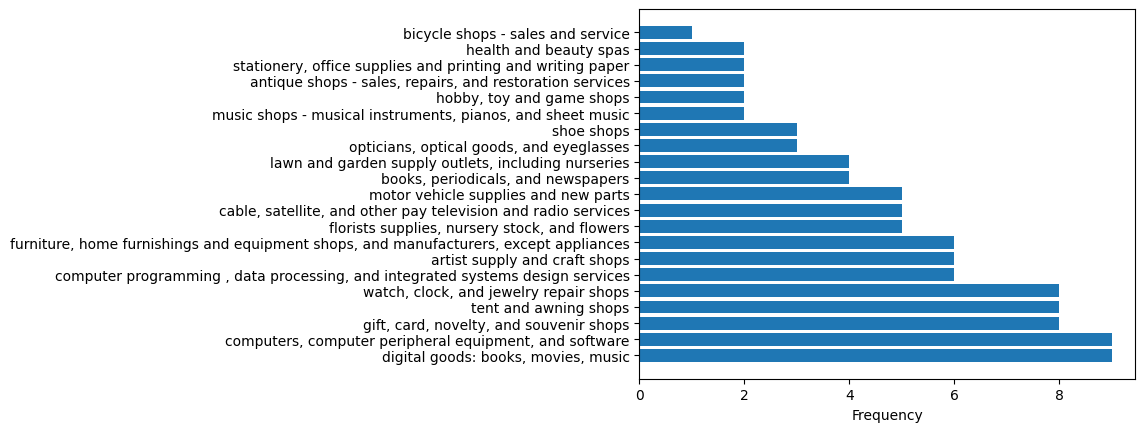

In [118]:
tags_count = top100_merch.groupBy("tags") \
    .agg(
        count("merchant_abn").alias("count")
    ) \
    .orderBy(desc("count")) \
    .toPandas()

plt.barh(tags_count["tags"], tags_count["count"])
plt.xlabel("Frequency")

***

Let's see the distribution of the revenue bands

([<matplotlib.patches.Wedge at 0x7f0280674a30>,
 [Text(-0.06906950569907239, 1.0978294054098232, ' a'),
  Text(-0.559945695615242, -0.9468161479199448, ' b'),
  Text(0.9097885205557988, -0.6182918791840073, ' c')],
 [Text(-0.03767427583585766, 0.5988160393144489, '52.00'),
  Text(-0.30542492488104106, -0.5164451715926971, '29.00'),
  Text(0.4962482839395266, -0.33725011591854936, '19.00')])

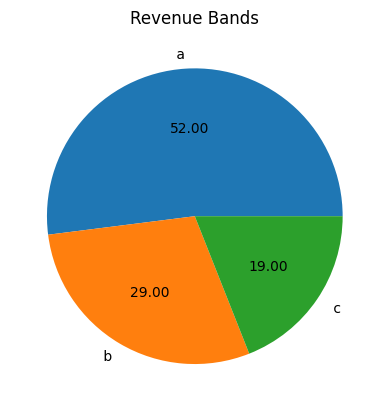

In [119]:
rev_band_count = top100_merch.groupBy("revenue_band") \
    .agg(
        count("merchant_abn").alias("count")
    ) \
    .orderBy(desc("count")) \
    .toPandas()

plt.title("Revenue Bands")
plt.pie(rev_band_count["count"], autopct='%.2f', labels=rev_band_count["revenue_band"])
